In [147]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

We want ot know how well the random forest can predict NDVI.
This is a particular case of NDVI because displays desertification over a region. showing a decreasing trend.

##### Performance Measure Selection
**root mean square error (RMSE)**
The most common.
- Follows the assumption that the errors are not biased.
- Is highly affected by outliers.

mean absolute percentage error (MAPE) - Sensitivie to values near 0 (our case) X

mean absolute scaled error (MASE) X

In [2]:
df_average = pd.read_csv('../ndvi_data/average_ndvi.csv')
df_average['date'] = pd.to_datetime(df_average.date)
df_average = df_average.drop(columns=['Unnamed: 0'])

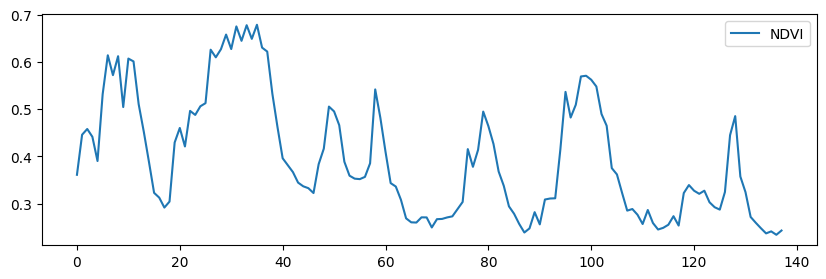

In [3]:
df_average.plot(figsize=(10,3), y='NDVI')
plt.show()

In [37]:

df_RF = df_average.copy()
df_RF ['Year'] = df_RF.date.dt.year
df_RF ['Month'] = df_RF.date.dt.month
df_RF = df_RF.dropna()

Correlation

In [54]:
def create_columns_shift(df,shift_number):
    df[f'{16*shift_number}DaysBefore'] = df.NDVI.shift(shift_number)

def drop_columns_shift(df, shift_number):
    df = df.drop(columns=[f'{16*shift_number}DaysBefore'], inplace=True)

In [87]:
for i in range(1,22): create_columns_shift(df_RF,i) 
corr_matrix = df_RF.dropna().corr()
corr_matrix['NDVI'].sort_values(ascending=False)

NDVI             1.000000
16DaysBefore     0.933399
32DaysBefore     0.843607
48DaysBefore     0.733963
64DaysBefore     0.613239
80DaysBefore     0.488949
336DaysBefore    0.395665
96DaysBefore     0.380430
320DaysBefore    0.349770
304DaysBefore    0.294642
112DaysBefore    0.284555
288DaysBefore    0.237607
128DaysBefore    0.201812
272DaysBefore    0.176338
144DaysBefore    0.133954
256DaysBefore    0.129147
160DaysBefore    0.076767
240DaysBefore    0.068441
176DaysBefore    0.037521
224DaysBefore    0.027606
192DaysBefore    0.013480
208DaysBefore    0.009003
Month           -0.328676
Year            -0.506702
date            -0.565974
Name: NDVI, dtype: float64

we will use the first 4 columns

In [88]:
for i in range(5,22): drop_columns_shift(df_RF,i) 
df_RF.dropna(inplace=True)

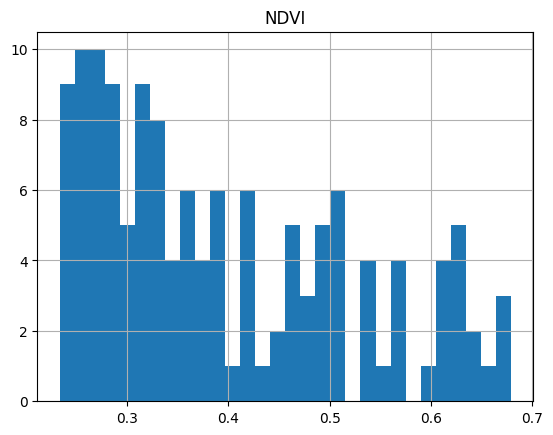

In [89]:
df_RF.hist('NDVI', bins=30)
plt.show()

In [80]:
df_RF.columns

Index(['date', 'NDVI', 'Year', 'Month', '16DaysBefore', '32DaysBefore',
       '48DaysBefore', '64DaysBefore'],
      dtype='object')

In [159]:
features_RF = tuple([np.array(df_RF[col]).reshape(-1,1) for col in [f'{i*16}DaysBefore' for i in range(1,5)]])
y = np.array(df_RF ['NDVI'])#.reshape(-1,1)
X = np.concatenate(features_RF, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X_train, X_test, y_train, y_test = X[:-20], X[-20:], y[:-20], y[-20:]

In [160]:
model = RandomForestRegressor(n_estimators=100,max_features=1,random_state=1)
model.fit(X_train,y_train)
y_pred = model.predict(X_train)
root_mean_squared_error(y_train, y_pred)

0.021623648937868313

Cross -validation

randomly splits the training set into 10 nonoverlapping
subsets called folds, then it trains and evaluates the model 10
times, picking a different fold for evaluation every time and using the other 9
folds for training.

In [164]:
model = RandomForestRegressor(n_estimators=100,max_features=6,random_state=1)

rmse_model = -cross_val_score(model, X_train, y_train, scoring="neg_root_mean_squared_error", cv=20)
pd.Series(rmse_model).describe()

count    20.000000
mean      0.049719
std       0.021327
min       0.012400
25%       0.039223
50%       0.051348
75%       0.061778
max       0.084927
dtype: float64

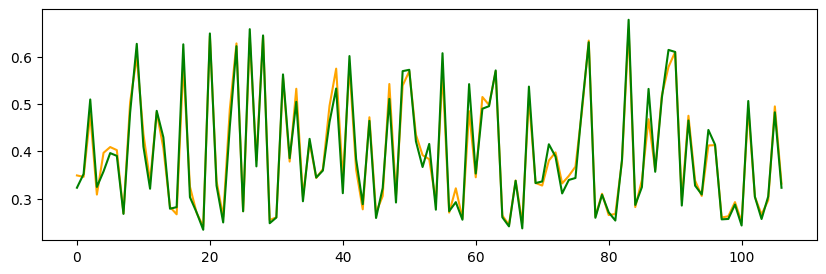

In [146]:
#y_pred = model.predict(X_test)
plt.figure(figsize=(10,3))
plt.plot(y_pred, label = 'Predicted', c = 'orange')
plt.plot(y_train, label = 'Predicted', c = 'green')
#plt.plot(range(118,138),y_pred, label = 'Predicted', c = 'orange')
#plt.plot(df_average.NDVI, label = 'Real', c = 'green')